# AUTOENCODER WITH EFFICIENT-NET

Andreas Mardohar Kristianto - 2602100096

In [2]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [4]:
# Define the AdvancedAutoencoder class
class AdvancedAutoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        efficientnet = models.efficientnet_b0(weights='DEFAULT')
        self.encoder = nn.Sequential(*list(efficientnet.features))
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(1280, 512, 4, 2, 1),
            nn.InstanceNorm2d(512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.ConvTranspose2d(512, 256, 4, 2, 1),
            nn.InstanceNorm2d(256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3),
            nn.ConvTranspose2d(256, 128, 4, 2, 1),
            nn.InstanceNorm2d(128),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(128, 64, 4, 2, 1),
            nn.InstanceNorm2d(64),
            nn.LeakyReLU(0.2),
            nn.ConvTranspose2d(64, 3, 4, 2, 1),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [5]:
def calculate_accuracy(input_tensor, output_tensor):
    mse = nn.functional.mse_loss(input_tensor, output_tensor, reduction='none')
    pixel_accuracy = 1 - mse.mean(dim=(1, 2, 3))
    return pixel_accuracy.mean().item()

In [8]:
def train():
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    transform = transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    # Food-101 dataset will be automatically downloaded
    dataset = datasets.Food101(root='./data', split='train', transform=transform, download=True)
    dataloader = DataLoader(dataset, batch_size=16, shuffle=True, num_workers=4)
    
    model = AdvancedAutoencoder().to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.AdamW(model.parameters(), lr=0.0001, weight_decay=0.01)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=10)
    
    epochs = 10
    losses = []
    accuracies = []
    
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        total_accuracy = 0
        for batch_idx, (data, _) in enumerate(dataloader):
            data = data.to(device)
            optimizer.zero_grad()
            output = model(data)
            loss = criterion(output, data)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
            
            # Calculate batch accuracy
            accuracy = calculate_accuracy(data, output)
            total_accuracy += accuracy
            
            if batch_idx % 100 == 0:
                print(f'Epoch: {epoch}, Batch: {batch_idx}, Loss: {loss.item():.4f}, Accuracy: {accuracy:.4f}')
        
        scheduler.step()
        avg_loss = total_loss / len(dataloader)
        avg_accuracy = total_accuracy / len(dataloader)
        losses.append(avg_loss)
        accuracies.append(avg_accuracy)
        print(f'Epoch {epoch} - Avg Loss: {avg_loss:.4f}, Avg Accuracy: {avg_accuracy:.4f}')
        torch.save(model.state_dict(), f'autoencoder_epoch_{epoch}.pth')
    
    # Plot loss and accuracy
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(losses, label='Loss')
    plt.title('Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(accuracies, label='Accuracy', color='orange')
    plt.title('Training Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

Epoch: 0, Batch: 0, Loss: 1.7273, Accuracy: -0.7273
Epoch: 0, Batch: 100, Loss: 0.9854, Accuracy: 0.0146
Epoch: 0, Batch: 200, Loss: 0.9549, Accuracy: 0.0451
Epoch: 0, Batch: 300, Loss: 0.6420, Accuracy: 0.3580
Epoch: 0, Batch: 400, Loss: 0.6954, Accuracy: 0.3046
Epoch: 0, Batch: 500, Loss: 0.6078, Accuracy: 0.3922
Epoch: 0, Batch: 600, Loss: 0.5144, Accuracy: 0.4856
Epoch: 0, Batch: 700, Loss: 0.4991, Accuracy: 0.5009
Epoch: 0, Batch: 800, Loss: 0.5709, Accuracy: 0.4291
Epoch: 0, Batch: 900, Loss: 0.5225, Accuracy: 0.4775
Epoch: 0, Batch: 1000, Loss: 0.4942, Accuracy: 0.5058
Epoch: 0, Batch: 1100, Loss: 0.5868, Accuracy: 0.4132
Epoch: 0, Batch: 1200, Loss: 0.5232, Accuracy: 0.4768
Epoch: 0, Batch: 1300, Loss: 0.5032, Accuracy: 0.4968
Epoch: 0, Batch: 1400, Loss: 0.4478, Accuracy: 0.5522
Epoch: 0, Batch: 1500, Loss: 0.5585, Accuracy: 0.4415
Epoch: 0, Batch: 1600, Loss: 0.5131, Accuracy: 0.4869
Epoch: 0, Batch: 1700, Loss: 0.4532, Accuracy: 0.5468
Epoch: 0, Batch: 1800, Loss: 0.3866, Ac

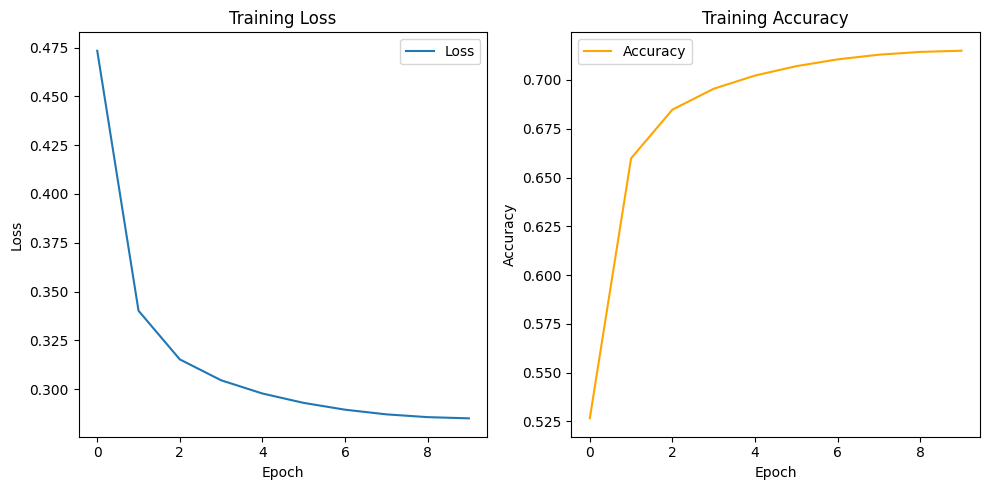

In [9]:
# Train the model
train()

Training
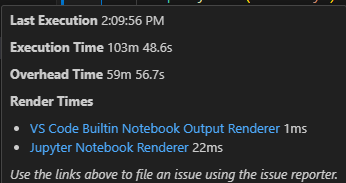